This notebook describes the harvesting process of the Elevation variable. The data is sourced from USGS's GMTED2010 product. GMTED2010 is a machine-learning model that estimates a place's elevation through satellite imagery. Data can be accessed through EarthExplorer https://earthexplorer.usgs.gov/, and is subsetted into different tiles. We only downloaded the tiles useful to the study.

Visualization of the different files.

C:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


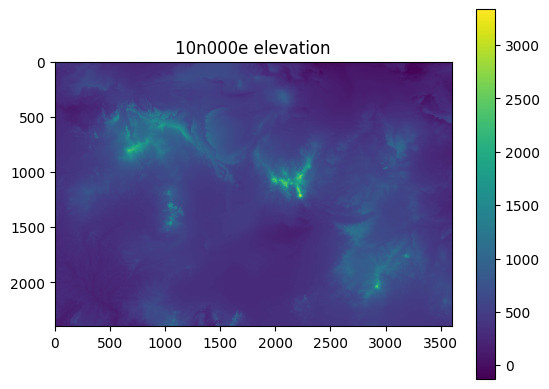

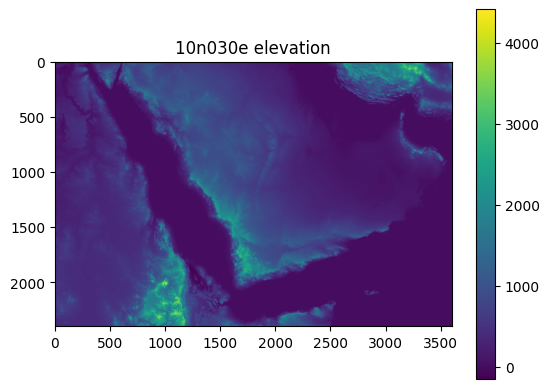

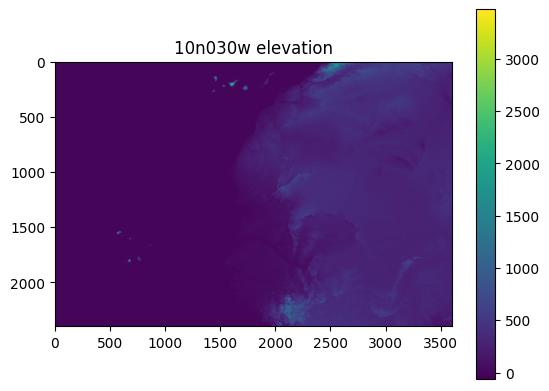

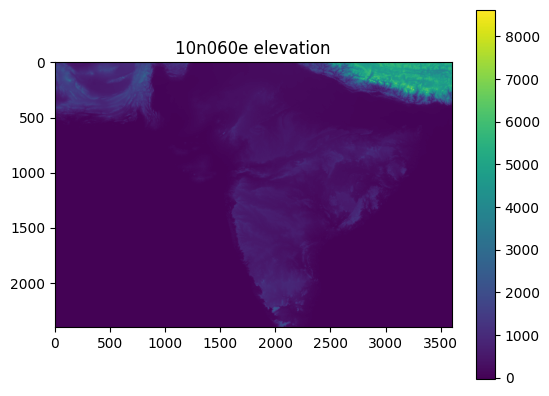

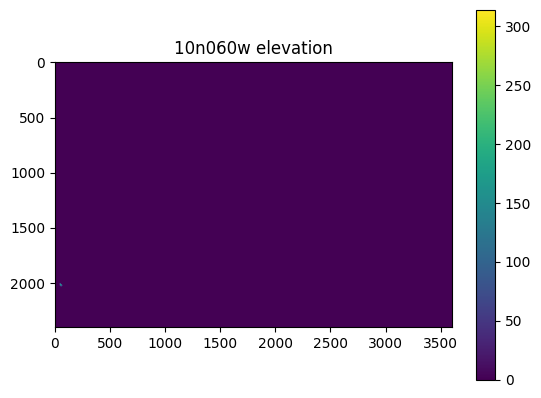

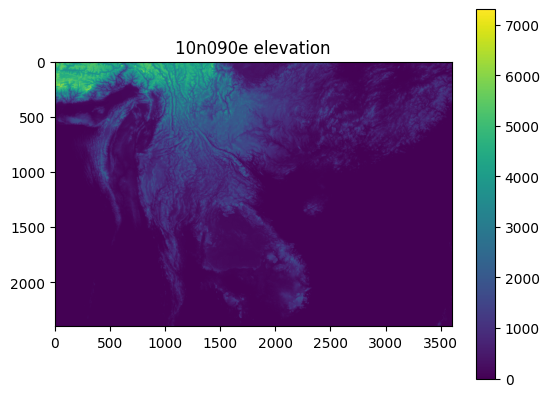

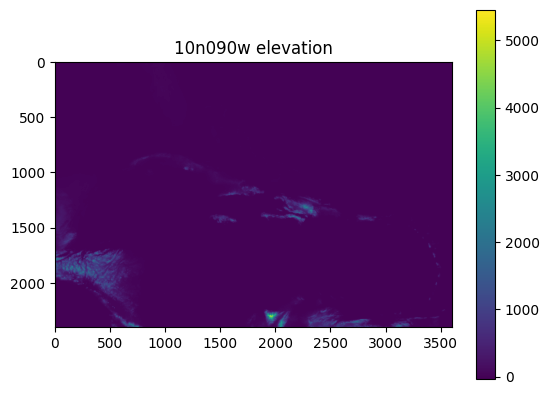

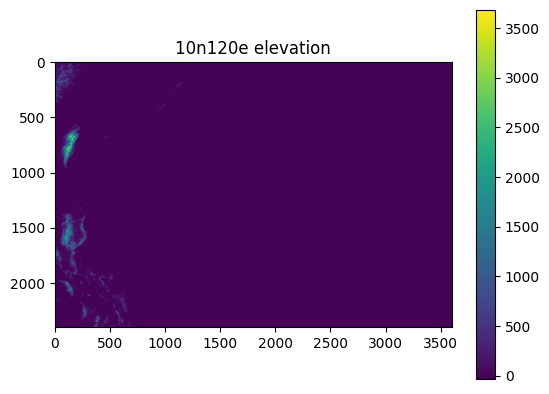

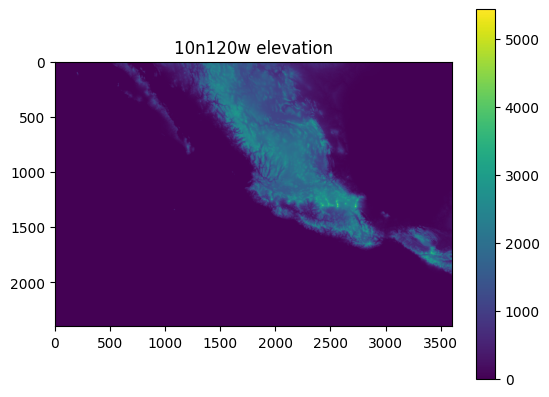

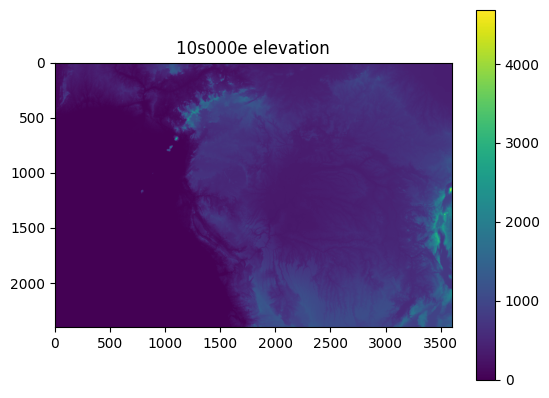

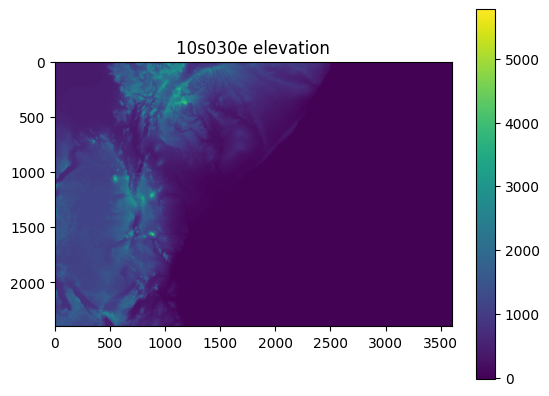

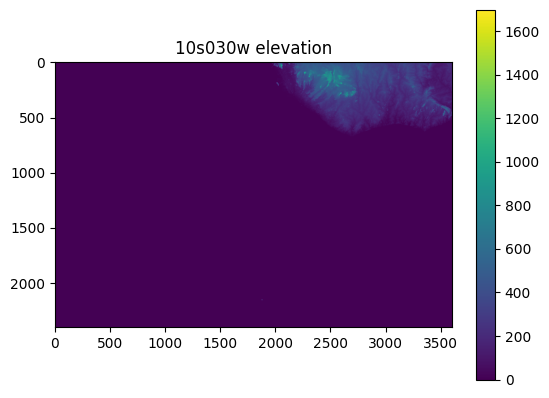

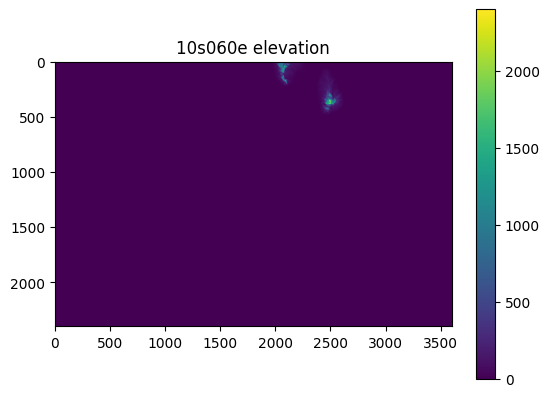

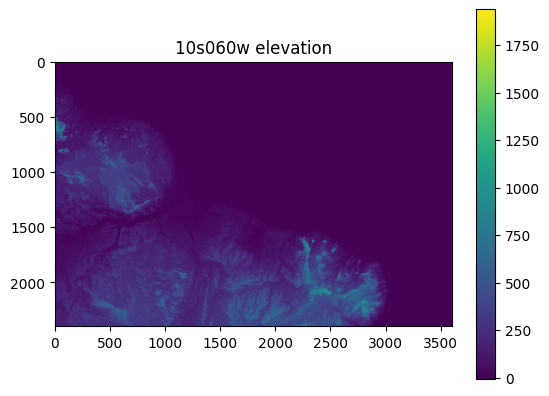

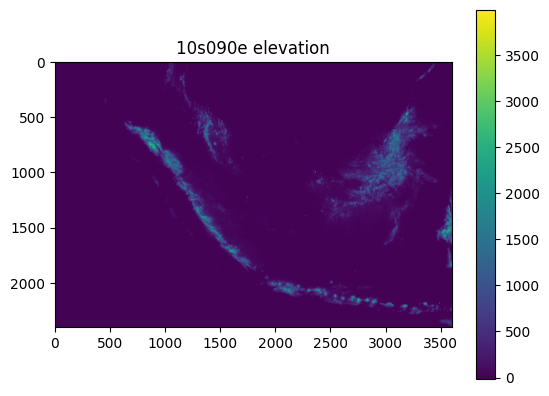

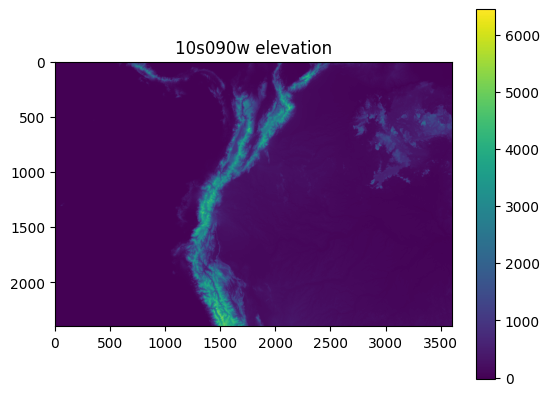

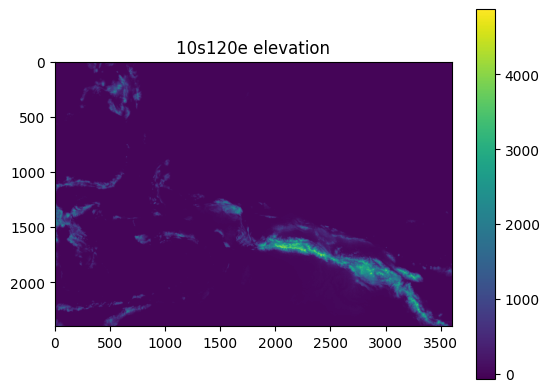

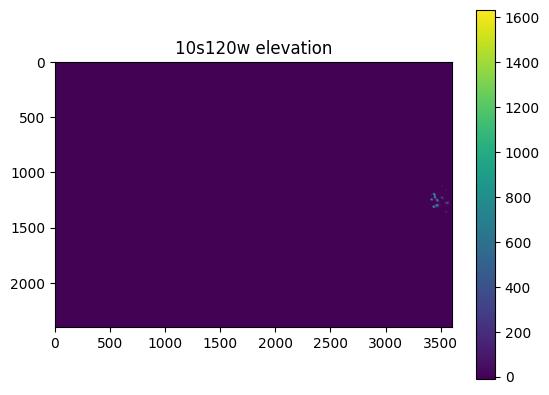

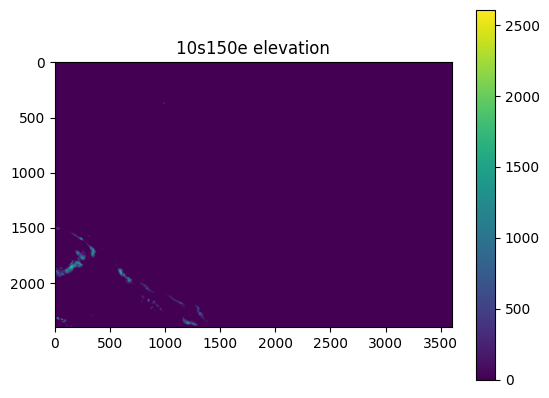

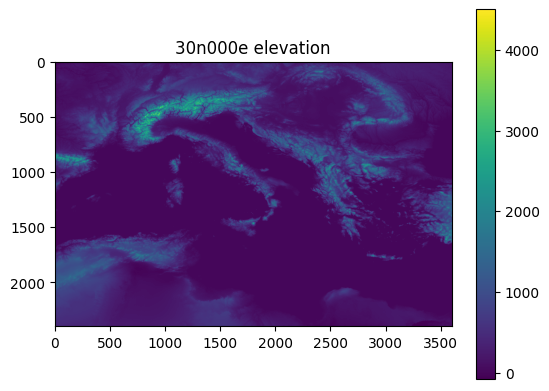

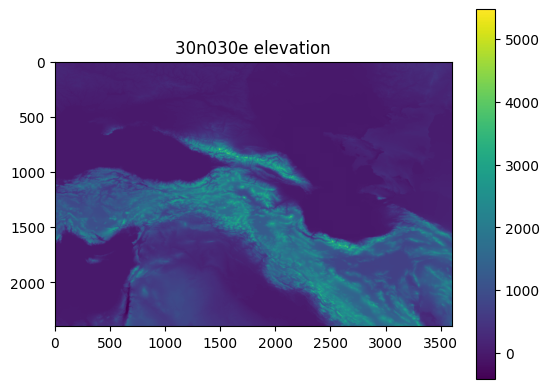

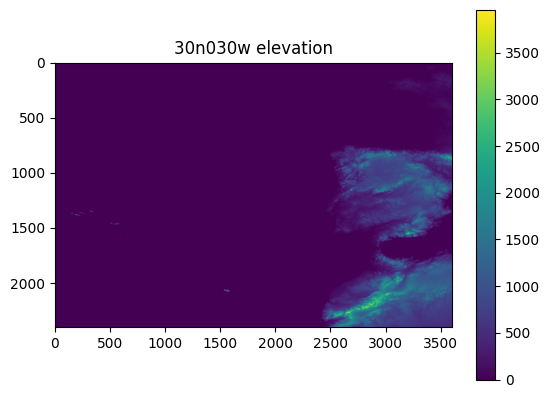

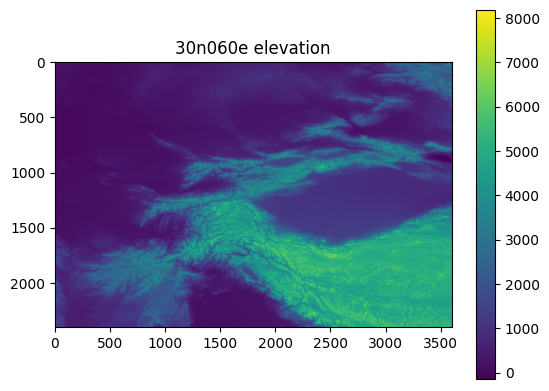

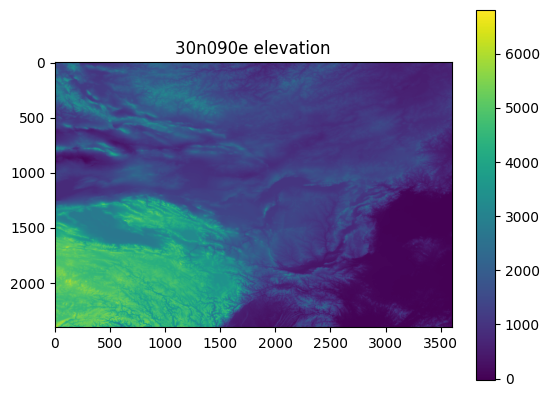

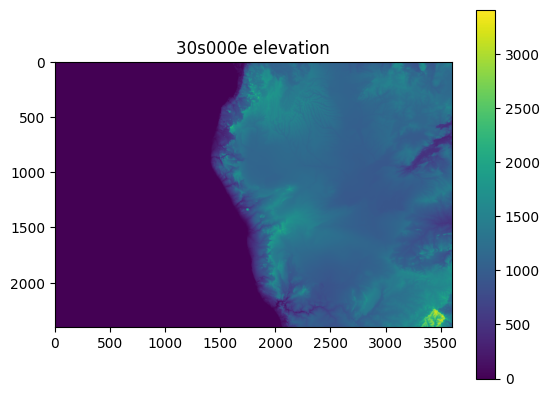

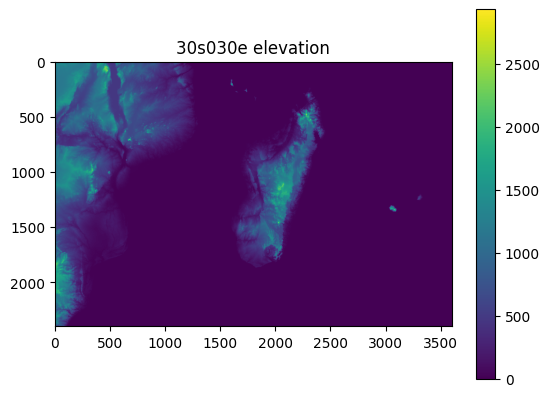

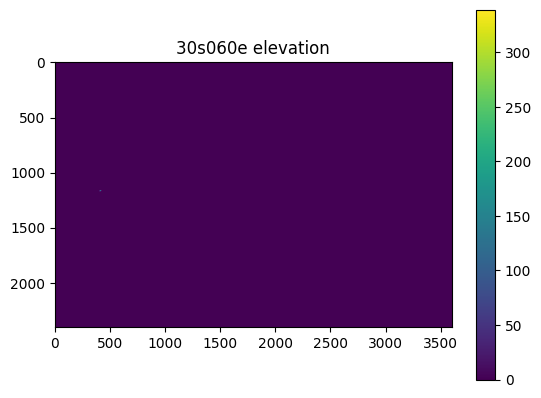

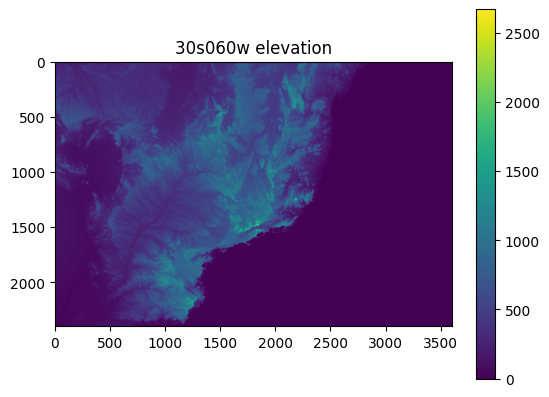

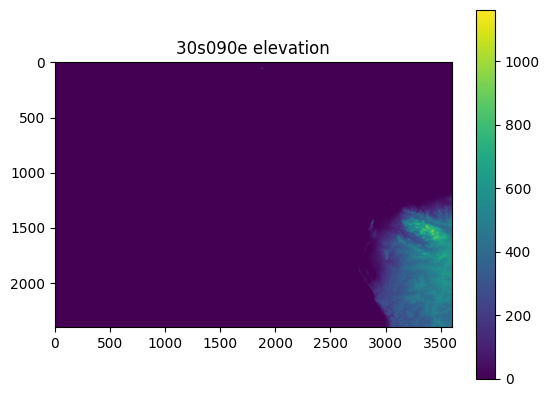

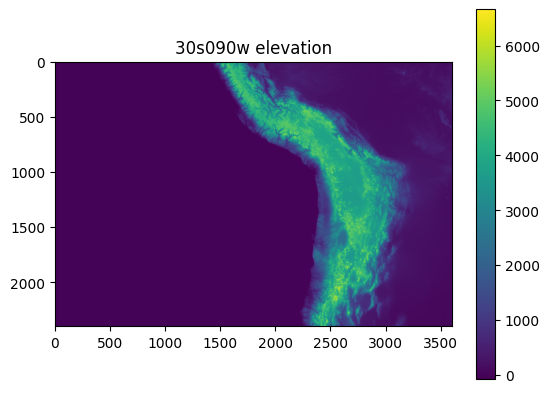

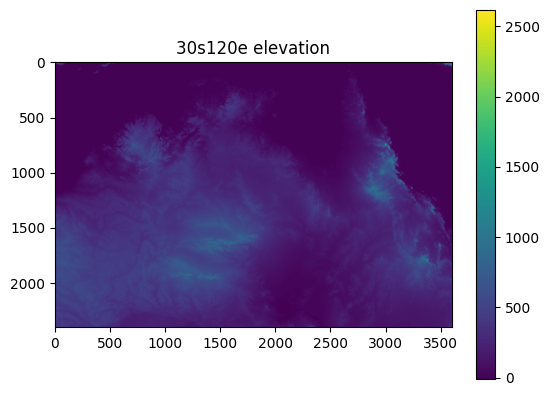

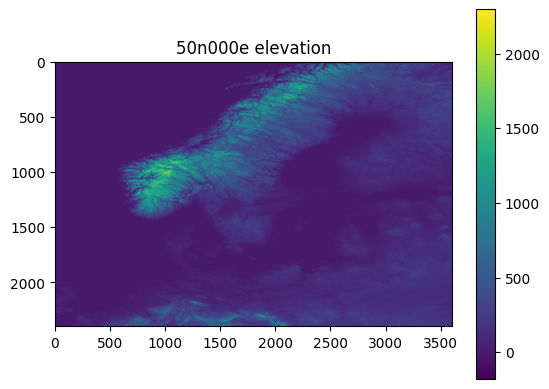

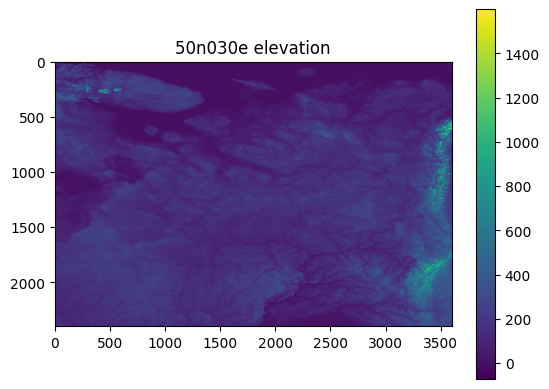

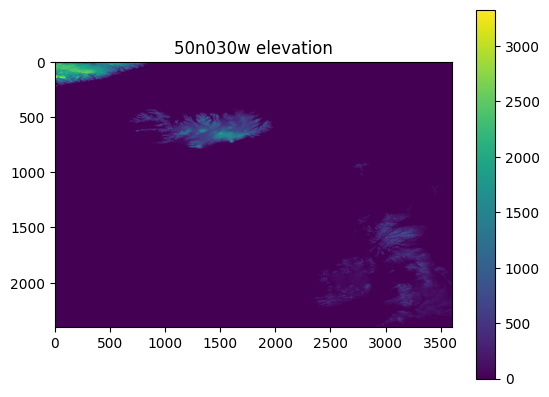

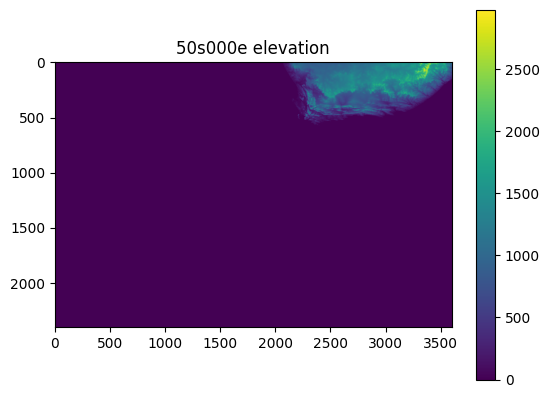

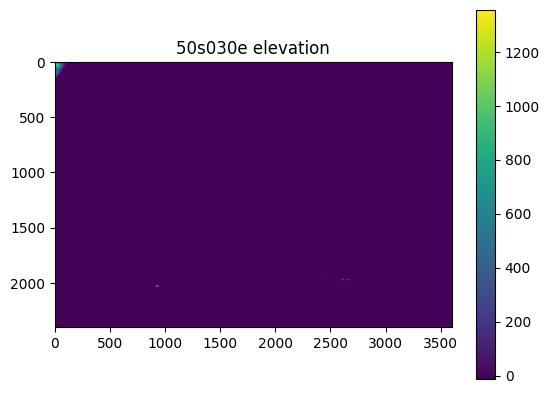

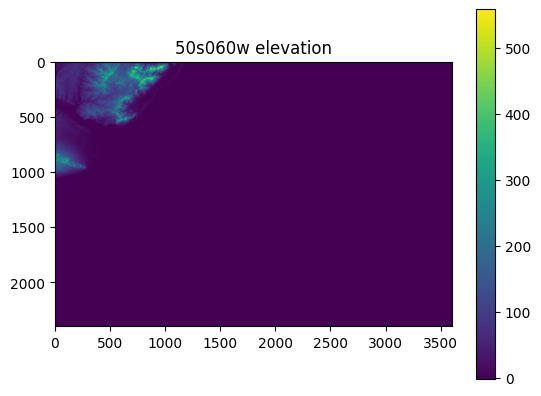

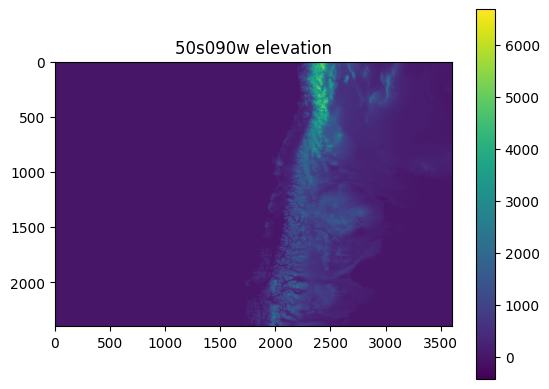

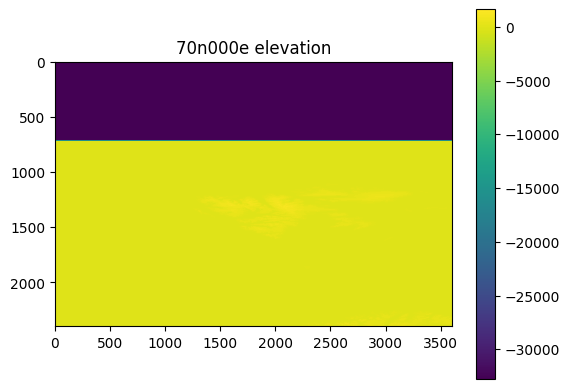

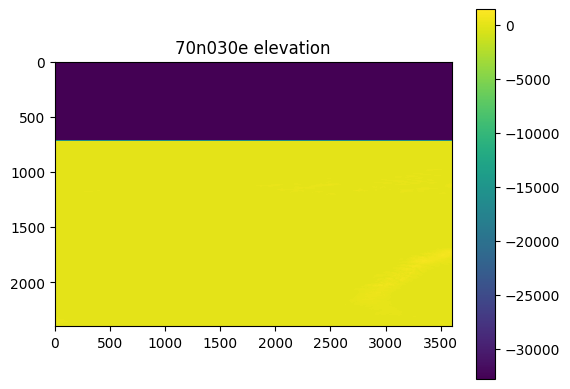

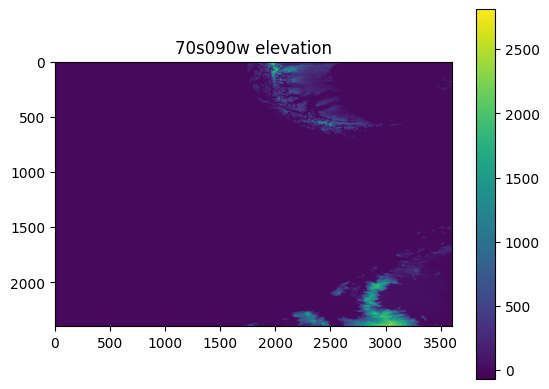

In [1]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np

cart = "C:\\Users\\Luca\\Downloads\\elevation"

for file in os.listdir(cart):
    nome = file[:7]
    el = gdal.Open(f'{cart}\\{file}')
    el_array = el.ReadAsArray()

    plt.figure()
    plt.title(f'{nome} elevation')
    plt.imshow(el_array)
    plt.colorbar()
    plt.show()

In [2]:
import pandas as pd
import rasterio as rio
import numpy as np
import os
from pyquadkey2 import quadkey

Below is the process of reading of a single elevation file. As a .geotiff file, you can read how its structured in the Radiation notebook. What we need to know is that each elevation value is tied to its coordinates via its indexed position in the array.

In [79]:
cart = "C:\\Users\\Luca\\Downloads\\elevation"
file = os.listdir(cart)[0]

with rio.open(f'{cart}\\{file}') as src:
    
    # Se lee la imagen
    print('reading...')
    image = src.read()
    
    # Dimensiones de la imagen
    print('getting shapes...')
    bands, rows, cols = np.shape(image)
    print((bands, rows, cols))
    
    # La imagen 2D se convierte a 1D
    print('getting elevations...')
    image1 = image.reshape (rows*cols,bands)
    
    # bounding box de la imagen
    print('getting bounds...')
    l,b,r,t = src.bounds
    print(f'lat: {b,t}, lon: {l,r}')
    
    # Resolution of image
    print('getting resolution...')
    res = src.res
    print(res)
    
    # Coordenadas X
    print('getting the coordinates...')
    X = np.arange(l, r, res[0])
    
    # Coordenadas Y
    Y = np.arange(t, b, -res[0])

    print('getting meshgrid...')
    X,Y = np.meshgrid(X,Y)
    X = np.array(X.flatten())
    Y = np.array(Y.flatten())

    print('creating dataframe...')
    data = pd.DataFrame()
    data['long'] = X
    data['lat'] = Y
    data['elevation'] = image1

reading...
getting shapes...
(1, 2400, 3600)
getting elevations...
getting bounds...
lat: (9.999861111111112, 29.999861111111112), lon: (-0.0001388888888888889, 29.999861111111112)
getting resolution...
(0.008333333333333333, 0.008333333333333333)
getting the coordinates...
getting meshgrid...
creating dataframe...


In [80]:
data

,long,lat,elevation
0,-0.000139,29.999861,467
1,0.008194,29.999861,472
2,0.016528,29.999861,461
3,0.024861,29.999861,473
4,0.033194,29.999861,459
...,...,...,...
8639995,29.958194,10.008194,415
8639996,29.966528,10.008194,415
8639997,29.974861,10.008194,415
8639998,29.983194,10.008194,414


In [81]:
data.elevation.describe()

count    8.640000e+06
mean     4.977420e+02
std      2.537879e+02
min     -1.290000e+02
25%      3.360000e+02
50%      4.570000e+02
75%      6.010000e+02
max      3.335000e+03
Name: elevation, dtype: float64

We assign to each point its quadkey 14 tile and we estimate the tile's true elevation value to be the average of all the points in the tile.

In [82]:
data['quadkey'] = data.apply(lambda x: str(quadkey.from_geo((x['lat'], x['long']), 14)), axis=1)

In [83]:
data = data.groupby('quadkey', as_index = False).elevation.mean()
data

,quadkey,elevation
0,03313113311333,467.000000
1,03313113313111,457.333333
2,03313113313113,451.500000
3,03313113313131,453.000000
4,03313113313133,444.000000
...,...,...
1333211,12232101230230,416.000000
1333212,12232101230231,415.666667
1333213,12232101230300,415.000000
1333214,12232101230302,415.666667


In [84]:
data.describe()

,elevation
count,1.333216e+06
mean,4.969362e+02
std,2.546272e+02
min,-1.256667e+02
25%,3.353333e+02
50%,4.570000e+02
75%,6.013333e+02
max,3.213333e+03


The read process is automated as follows. Notice that sometimes the script will generate a longitude or latitude array 1 value longer than it should. In this case, we will just remove the last value.

In [85]:
repo = "C:\\Users\\Luca\\Downloads\\RWI\\elevation"

for file in os.listdir(cart):
    nome = file[:7]
    print(f'reading {nome}...')
    with rio.open(f'{cart}\\{file}') as src:
    
        # Se lee la imagen
        print('reading...')
        image = src.read()
        
        # Dimensiones de la imagen
        print('getting shapes...')
        bands, rows, cols = np.shape(image)
        print((bands, rows, cols))
        
        # La imagen 2D se convierte a 1D
        print('getting elevations...')
        image1 = image.reshape (rows*cols,bands)
        
        # bounding box de la imagen
        print('getting bounds...')
        l,b,r,t = src.bounds
        print(f'lat: {b,t}, lon: {l,r}')
        
        # Resolution of image
        print('getting resolution...')
        res = src.res
        print(res)
        
        # Coordenadas X
        print('getting the coordinates...')
        X = np.arange(l, r, res[0])
        if len(X) > cols:
            X = X[:-1]
        
        # Coordenadas Y
        Y = np.arange(t, b, -res[0])
        if len(Y) > rows:
            Y = Y[:-1]
        
        print('getting meshgrid...')
        X,Y = np.meshgrid(X,Y)
        X = np.array(X.flatten())
        Y = np.array(Y.flatten())
    
    print('creating dataframe...')
    data = pd.DataFrame()
    data['long'] = X
    data['lat'] = Y
    data['elevation'] = image1

    print(f'dataframe created. shape: {data.shape}')

    print('getting quadkeys...')
    data['quadkey'] = data.apply(lambda x: str(quadkey.from_geo((x['lat'], x['long']), 14)), axis=1)

    print('grouping and exporting...')
    data = data.groupby('quadkey', as_index = False).elevation.mean()
    data.to_csv(f'{repo}\\{nome}_elevation.csv', index = False)
    print(f'unique quadkeys: {len(data)}, min/mean/max elevation: {(data.elevation.min(), data.elevation.mean(), data.elevation.max())}')
    print('-'*100)

reading 10n000e...
reading...
getting shapes...
(1, 2400, 3600)
getting elevations...
getting bounds...
lat: (9.999861111111112, 29.999861111111112), lon: (-0.0001388888888888889, 29.999861111111112)
getting resolution...
(0.008333333333333333, 0.008333333333333333)
getting the coordinates...
getting meshgrid...
creating dataframe...
dataframe created. shape: (8640000, 3)
getting quadkeys...
grouping and exporting...
unique quadkeys: 1333216, min/mean/max elevation: (-125.66666666666667, 496.93621772049283, 3213.3333333333335)
----------------------------------------------------------------------------------------------------
reading 10n030e...
reading...
getting shapes...
(1, 2400, 3600)
getting elevations...
getting bounds...
lat: (9.999861111111112, 29.999861111111112), lon: (29.999861111111112, 59.999861111111116)
getting resolution...
(0.008333333333333333, 0.008333333333333333)
getting the coordinates...
getting meshgrid...
creating dataframe...
dataframe created. shape: (8640000

AssertionError: 

There are some values with latitude higher then 85, which are not accepted by pyquadkey2's quadkey.from_geo() function. Luckily though, we see that all the values are equal to -32768, which is the identifier for missing values.

In [89]:
data[data.lat > 85].elevation.value_counts()

elevation
-32768    2160000
Name: count, dtype: int64

In [91]:
data.elevation.value_counts()

elevation
 0        5584287
-32768    2592000
 1           4701
 2           2946
 3           2221
           ...   
 1473           1
 1411           1
 1378           1
 1499           1
 1359           1
Name: count, Length: 1459, dtype: int64

We continue with the automation, this time dropping every missing value.

In [93]:
repo = "C:\\Users\\Luca\\Downloads\\RWI\\elevation"

for file in os.listdir(cart)[38:]:
    nome = file[:7]
    print(f'reading {nome}...')
    with rio.open(f'{cart}\\{file}') as src:
    
        # Se lee la imagen
        print('reading...')
        image = src.read()
        
        # Dimensiones de la imagen
        print('getting shapes...')
        bands, rows, cols = np.shape(image)
        print((bands, rows, cols))
        
        # La imagen 2D se convierte a 1D
        print('getting elevations...')
        image1 = image.reshape (rows*cols,bands)
        
        # bounding box de la imagen
        print('getting bounds...')
        l,b,r,t = src.bounds
        print(f'lat: {b,t}, lon: {l,r}')
        
        # Resolution of image
        print('getting resolution...')
        res = src.res
        print(res)
        
        # Coordenadas X
        print('getting the coordinates...')
        X = np.arange(l, r, res[0])
        if len(X) > cols:
            X = X[:-1]
        
        # Coordenadas Y
        Y = np.arange(t, b, -res[0])
        if len(Y) > rows:
            Y = Y[:-1]
        
        print('getting meshgrid...')
        X,Y = np.meshgrid(X,Y)
        X = np.array(X.flatten())
        Y = np.array(Y.flatten())
    
    print('creating dataframe...')
    data = pd.DataFrame()
    data['long'] = X
    data['lat'] = Y
    data['elevation'] = image1

    data.replace(to_replace = -32768, value = np.nan, inplace = True)
    data.dropna(inplace = True)
    
    print(f'dataframe created. shape: {data.shape}')

    print('getting quadkeys...')
    data['quadkey'] = data.apply(lambda x: str(quadkey.from_geo((x['lat'], x['long']), 14)), axis=1)

    print('grouping and exporting...')
    data = data.groupby('quadkey', as_index = False).elevation.mean()
    data.to_csv(f'{repo}\\{nome}_elevation.csv', index = False)
    print(f'unique quadkeys: {len(data)}, min/mean/max elevation: {(data.elevation.min(), data.elevation.mean(), data.elevation.max())}')
    print('-'*100)

reading 70n000e...
reading...
getting shapes...
(1, 2400, 3600)
getting elevations...
getting bounds...
lat: (69.99986111111112, 89.99986111111112), lon: (-0.0001388888888888889, 29.999861111111112)
getting resolution...
(0.008333333333333333, 0.008333333333333333)
getting the coordinates...
getting meshgrid...
creating dataframe...
dataframe created. shape: (6048000, 3)
getting quadkeys...
grouping and exporting...
unique quadkeys: 2294880, min/mean/max elevation: (0.0, 26.63643545632016, 1580.3333333333333)
----------------------------------------------------------------------------------------------------
reading 70n030e...
reading...
getting shapes...
(1, 2400, 3600)
getting elevations...
getting bounds...
lat: (69.99986111111112, 89.99986111111112), lon: (29.999861111111112, 59.999861111111116)
getting resolution...
(0.008333333333333333, 0.008333333333333333)
getting the coordinates...
getting meshgrid...
creating dataframe...
dataframe created. shape: (6048000, 3)
getting quadke

We create the final dataset as a concatenation of all the subset files. Notice that sometimes there will be duplicate quadkeys, as their points had been splitted across the bigger tiles. We will try to fix it by averaging their values, which isn't mathematically sound but should work either way.

In [1]:
import pandas as pd 
import os

repo = "C:\\Users\\Luca\\Downloads\\RWI\\elevation"

data = pd.DataFrame(columns = ['quadkey', 'elevation'])
for file in os.listdir(repo):
    name = file[:7]
    temp = pd.read_csv(f'{repo}\\{file}')

    data = pd.concat([data, temp], ignore_index = True)
    print(f'{name} df appended. current shape: {data.shape}')

C:\Users\Luca\AppData\Local\Temp\ipykernel_16100\830578019.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, temp], ignore_index = True)


10n000e df appended. current shape: (1333216, 2)
10n030e df appended. current shape: (2666432, 2)
10n030w df appended. current shape: (3999648, 2)
10n060e df appended. current shape: (5332864, 2)
10n060w df appended. current shape: (6666080, 2)
10n090e df appended. current shape: (7999296, 2)
10n090w df appended. current shape: (9332512, 2)
10n120e df appended. current shape: (10665728, 2)
10n120w df appended. current shape: (11998944, 2)
10s000e df appended. current shape: (13250200, 2)
10s030e df appended. current shape: (14501456, 2)
10s030w df appended. current shape: (15752712, 2)
10s060e df appended. current shape: (17003968, 2)
10s060w df appended. current shape: (18255224, 2)
10s090e df appended. current shape: (19506480, 2)
10s090w df appended. current shape: (20757736, 2)
10s120e df appended. current shape: (22008992, 2)
10s120w df appended. current shape: (23260248, 2)
10s150e df appended. current shape: (24511504, 2)
30n000e df appended. current shape: (26156168, 2)
30n030e

We create a subset consisting of only tiles that will be of use in the study.

In [2]:
data = data.groupby('quadkey', as_index = False).mean()
len(data)

63419237

In [3]:
data.to_csv(f'{repo}\\elevation.csv', index = False)

In [44]:
with open('quad_paesi2.txt', 'r') as file:
    list_quads = file.read()
    list_quads = list_quads.split(',')

In [45]:
len(list_quads)

3839219

In [46]:
data = pd.read_csv(f'{repo}\\elevation.csv')
data

,quadkey,elevation
0,1111333331333,0.000000
1,1111333333131,0.000000
2,1111333333331,0.000000
3,1113111111113,0.000000
4,1113111111313,0.000000
...,...,...
63419232,31121230121221,383.666667
63419233,31121230121222,338.444444
63419234,31121230121223,367.888889
63419235,31121230121230,373.500000


In [47]:
data = data.astype({'quadkey': 'str'})

In [48]:
df = data[data.quadkey.isin(list_quads)]
len(df)

3838983

There are few quadkeys missing from the dataset, which we can pinpoint to the Scandinavian Peninsula. As the number of missing values is very small, we can leave it as-is and just imputate it later.

In [49]:
len(list_quads) - len(df)

236

In [50]:
df.to_csv(f'{repo}\\elevation_quadkeys_utili.csv', index = False)

In [51]:
missing = set(list_quads) - set(df.quadkey)

In [52]:
with open('elev_miss.txt', 'w') as file:
    file.write(','.join(missing))

In [53]:
from pyquadkey2 import quadkey

for miss in missing:
    print(quadkey.from_str(miss).to_geo())

(69.107776773314, 27.7734375)
(69.983015102873, 23.35693359375)
(69.649446368846, 29.0478515625)
(68.382996340596, 16.6552734375)
(68.807985556146, 17.11669921875)
(69.907667341085, 20.1708984375)
(68.807985556146, 26.279296875)
(70.340926794752, 25.02685546875)
(68.807985556146, 14.5458984375)
(69.349338639776, 26.52099609375)
(70.815812159313, 27.94921875)
(68.624543663447, 27.509765625)
(67.958147861015, 15.22705078125)
(69.983015102873, 28.54248046875)
(70.815812159313, 28.0810546875)
(70.590720662655, 29.00390625)
(70.207435706706, 22.32421875)
(69.907667341085, 23.22509765625)
(69.983015102873, 29.53125)
(69.44984199907, 25.0048828125)
(68.966278627247, 17.55615234375)
(68.624543663447, 27.53173828125)
(69.907667341085, 27.0263671875)
(70.757965626549, 27.333984375)
(70.866290562904, 24.67529296875)
(70.815812159313, 23.4228515625)
(68.807985556146, 16.50146484375)
(69.44984199907, 30.03662109375)
(70.466207422265, 27.09228515625)
(70.590720662655, 27.26806640625)
(70.53222152642